## Plots for experiments in population setting

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from matplotlib import gridspec
from src import utils
import pickle

In [2]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

### Load and process data

In [3]:
def load_experiments(filename):
    f = open(filename, "rb")
    results = pickle.load(f)
    return results[0], results[1::]

def merge_runs(old, new, min_merge=False):
    if len(old) == len(new) or (len(old) < len(new) and min_merge):
        for i in range(len(old)):
            old[i] += new[i]
    else:
        raise Exception("Cannot merge")
    return old

In [4]:
filenames = [
    "experiments/results_1589124724_runs:8_max_iter:-1_random_state:0_tag:may9pop_G:500_k:3.0_p_min:15_p_max:15_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:False.pickle",
    "experiments/results_1589130144_runs:8_max_iter:-1_random_state:1_tag:may9pop_G:500_k:3.0_p_min:15_p_max:15_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:False.pickle"
]
    
cases, results = load_experiments(filenames[0])
for filename in filenames[1::]:
        print("Loading %s" % filename)
        new_cases, new_results = load_experiments(filename)
        cases += new_cases
        for k in range(len(results)):
            results[k] = merge_runs(results[k], new_results[k])
max_iter = 15
print("\nLoaded a total of %d graphs with %d runs each" % (len(results[0][0]), len(results[0])))

Loading experiments/results_1589130144_runs:8_max_iter:-1_random_state:1_tag:may9pop_G:500_k:3.0_p_min:15_p_max:15_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:False.pickle

Loaded a total of 1000 graphs with 8 runs each


In [5]:
def hamming_distance(A,B,p):
    a = np.zeros(p)
    b = np.zeros(p)
    a[list(A)] = 1
    b[list(B)] = 1
    return scipy.spatial.distance.hamming(a, b)

In [6]:
runs = len(results[0])
N = len(results[0][0])
P = len(results)

no_ints = np.zeros((len(results), runs, N))
#all_trajectories_jac = {}
all_trajectories_ham = {}
names = []
for k, policy_runs in enumerate(results):
    name = policy_runs[0][0].policy
    names.append(name)
    trajectories_jac = []
    trajectories_ham = []
    for i,run_results in enumerate(policy_runs):
        for j, result in enumerate(run_results):
            estimates = result.estimates() + [result.estimate]
            try:
                # checks whether truth is contained in estimates and retrieves index
                no_ints[k, i, j] = estimates.index(cases[j].truth)
            except ValueError:
                # if not, add max. intervention number
                no_ints[k, i, j] = len(result.interventions())
            #trajectory_jac = list(map(lambda estimate: jaccard_distance(cases[j].truth, estimate), estimates))
            trajectory_ham = list(map(lambda estimate: hamming_distance(cases[j].truth, estimate, cases[j].sem.p), estimates))
            #trajectories_jac.append(trajectory_jac)
            trajectories_ham.append(trajectory_ham)
    #all_trajectories_jac[name] = trajectories_jac
    all_trajectories_ham[name] = trajectories_ham

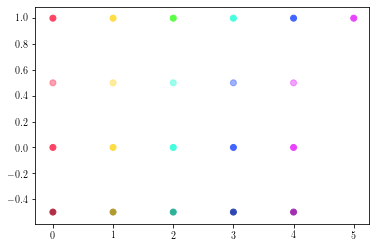

In [7]:
# Colors

def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#4365ff", "#e943ff"]#np.array([cmap(i) for i in range(2,20)])
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
base = [base[i] for i in [0,1,3,4,5]]
colors = to_rgb(base)
colorsa = to_rgb(base, a=0.5)
colorsb = to_rgb(base, b=0.7)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

In [8]:
# For legend size
from matplotlib.font_manager import FontProperties

fontP = FontProperties()
fontP.set_size('small')

**Summary of graphs used**

1000 graphs in total


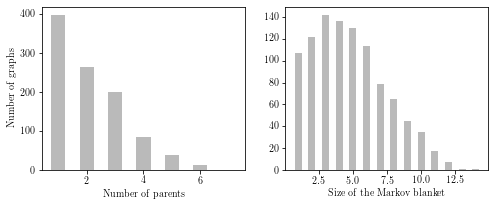

In [9]:
n_parents = np.zeros(N)
n_vars = np.zeros(N)
size_mb = np.zeros(N)
for i, case in enumerate(cases):
    n_parents[i] = len(case.truth)
    n_vars[i] = case.sem.p
    mb = utils.graph_info(case.target, case.sem.W)[3]
    size_mb[i] = len(mb)

def plot_hist(data, title):
    bins = np.arange(data.min(), data.max()+2)-0.5
    hist = plt.hist(data, bins, rwidth=0.5, align='mid', color="#BABABA")#colorsb[2])
    plt.xlabel(title)
    
plt.figure(figsize=(8,3))
#plt.subplot(131), plot_hist(n_vars, "Number of variables")
plt.subplot(121), plot_hist(n_parents, "Number of parents"), plt.ylabel("Number of graphs")
plt.subplot(122), plot_hist(size_mb, "Size of the Markov blanket")
print("%d graphs in total" % N)

### Plot A: True positive recovery

In [30]:
mask = []
degree = 15
for i, case in enumerate(cases):
    parents, _, _, mb = utils.graph_info(case.target, case.sem.W)
    if len(parents) < len(mb) and case.sem.p == degree:
        mask.append(i)
len(mask)

595

In [31]:
names

['random', 'markov', 'markov + r']

(0.6823529411764706, 0.7803921568627451, 0.9098039215686274, 1.0)


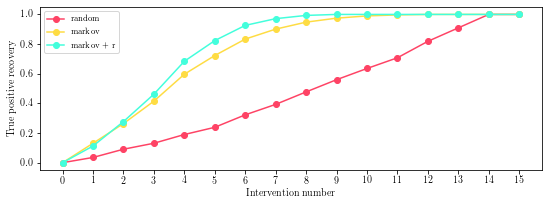

In [33]:
hm_dist = np.zeros((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(all_trajectories_ham.items()):
    for j, trajectory in enumerate(trajectories):
        hm_dist[i, j, :] = np.array(trajectory)
mean = np.mean(hm_dist[:, mask, :] == 0, axis=1)

x_axis = np.arange(0, degree+1)

cmap = matplotlib.cm.get_cmap('tab20')
rgba = cmap(1)
print(rgba)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 3))
for i,name in enumerate(names):
    plt.plot(x_axis, mean[i,:], linewidth=1.5, color=colors[i], marker='o', label=name)
    #plt.errorbar(x_axis, mean[i,:], std[i,:], linewidth=1, color=colorsa[j])#, uplims=True, lolims=True)
    #top = mean[i,:] + std[i,:]#q75[i,:]#
    #bottom = np.maximum(0, mean[i,:] - std[i,:])#q25[i,:]#
    #plt.plot(x_axis, top, ls=":", color=colorsa[j])
    #plt.plot(x_axis, bottom, ls=":", color=colorsa[j])
plt.xlabel("Intervention number")
plt.ylabel("True positive recovery")
axes.set_xticks(x_axis)
plt.legend(prop=fontP)
plt.savefig('figures/tpr_population_ratio_comparisons.pdf', bbox_inches='tight')

### Plot B: Number of interventions required

[Text(0, 0, 'random\n(8.64)'),
 Text(1, 0, 'markov\n(4.29)'),
 Text(2, 0, 'markov + r\n(3.67)')]

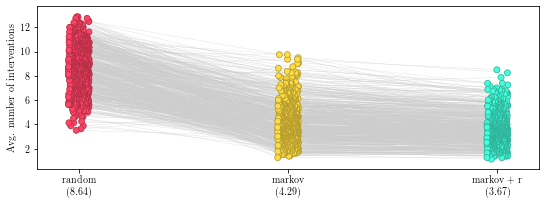

In [17]:
idx = mask
Ns = len(idx)
means = np.mean(no_ints[:,:,idx], axis=1)
plt.figure(figsize = (9,3))
dev = 0.05
xaxis = np.tile([0,1,2], (Ns, 1)) - np.outer(np.linspace(-dev, dev, Ns), [1,1,1])
ecolor = "#cdcdcd"
for i in range(Ns):
    plt.plot(xaxis[i,:], means[:, i].T, color=ecolor, zorder=0, LineWidth=0.25)
for i in range(Ns):
    plt.scatter(xaxis[i,:], means[:, i].T, c=colors[[0,1,2]], marker="o", zorder=1, edgecolors=colorsb[[0,1,2]], linewidths=0.75)
ax = plt.gca()
ax.set_xticks([0,1,2])
plt.xlim([-0.2, 2.2])
plt.ylabel("Avg. number of interventions")
plt.savefig('figures/int_numbers_population.pdf', bbox_inches='tight')
total_averages = means.mean(axis=1)
labels = []
for i,name in enumerate(names):
    labels.append(name + "\n(%0.2f)" % total_averages[i])
ax.set_xticklabels(labels, ha="center", rotation=0)

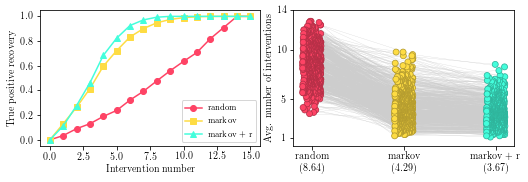

In [41]:
# Together
gs = gridspec.GridSpec(1, 2, wspace=0.15, hspace=0.3)
plt.figure(figsize=(8.5,2.5))


# PLOT A
plt.subplot(gs[0])
ax = plt.gca()
hm_dist = np.zeros((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(all_trajectories_ham.items()):
    for j, trajectory in enumerate(trajectories):
        hm_dist[i, j, :] = np.array(trajectory)
mean = np.mean(hm_dist[:, mask, :] == 0, axis=1)
x_axis = np.arange(0, degree+1)
markers = ["o", "s", "^"]
for i,name in enumerate(names):
    plt.plot(x_axis, mean[i,:], linewidth=1.5, color=colors[i], marker=markers[i], label=name)
plt.xlabel("Intervention number")
plt.ylabel("True positive recovery")
axes.set_xticks(x_axis)
plt.legend(prop=fontP)

# PLOT B
plt.subplot(gs[1])
ax = plt.gca()
idx = mask
Ns = len(idx)
means = np.mean(no_ints[:,:,idx], axis=1)
dev = 0.1
xaxis = np.tile([0,1,2], (Ns, 1)) - np.outer(np.linspace(-dev, dev, Ns), [1,1,1])
ecolor = "#cdcdcd"
for i in range(Ns):
    plt.plot(xaxis[i,:], means[:, i].T, color=ecolor, zorder=0, LineWidth=0.25)
for i in range(Ns):
    plt.scatter(xaxis[i,:], means[:, i].T, c=colors[[0,1,2]], marker="o", zorder=1, edgecolors=colorsb[[0,1,2]], linewidths=0.75)
ax = plt.gca()
ax.set_xticks([0,1,2])
plt.xlim([-0.2, 2.2])
plt.ylabel("Avg. number of interventions")
plt.savefig('figures/int_numbers_population.pdf', bbox_inches='tight')
total_averages = means.mean(axis=1)
labels = []
for i,name in enumerate(names):
    labels.append(name + "\n(%0.2f)" % total_averages[i])
ax.set_xticklabels(labels, ha="center", rotation=0)
ax.set_yticks([1, 5, 10, 14])

plt.savefig('figures/population_together.pdf', bbox_inches='tight')

### Plot C: Distribution of number of interventions required

In [ ]:
#idx, = np.where(no_ints[2,:,:].mean(axis=0) > 1)
idx = [9,2,3,4,6,7,1,10,11,13,14,15]#list(range(16))
Ns = len(idx)
all_data = np.zeros((runs,Ns*3))
all_data[:, 0:Ns*3:3] = no_ints[2,:,idx].T
all_data[:, 1:Ns*3:3] = no_ints[0,:,idx].T
all_data[:, 2:Ns*3:3] = no_ints[1,:,idx].T
labels = (np.floor(np.arange(0,Ns*3) / 3) + 1).astype(int)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(9, 3))
bplot = axes.boxplot(all_data,
                     vert=True,  # vertical box alignment
                     patch_artist=True,
                     medianprops = {'color': 'black'},
                     labels = labels)
for i,patch in enumerate(bplot['boxes']):
    patch.set_facecolor(colors[i%3])
axes.set_xticks([])
plt.ylabel("Number of interventions")
plt.legend(bplot['boxes'][0:3], ['random', 'markov', 'markov + e + r'], loc=8, prop=fontP, ncol=3, bbox_to_anchor=[0.5,-0.15]);
for i in range(Ns):
    x = i*3+0.5
    plt.plot([x,x], [0.75,max_iter-0.75], c='#000000', LineWidth=1)
plt.ylim(0.5,max_iter-0.5)
plt.savefig("figures/intervention_distributions_population.pdf", bbox_inches='tight')